In [ ]:
!pip install nsepy

In [24]:
import time
import pandas as pd
from datetime import date
from numpy import NaN

from nsepy.derivatives import get_expiry_date
from nsepy import get_history

In [ ]:
start_date = date(2002,1,1)
# end_date = date(2023,1,1)
end_date = date.today()

nifty_options = []
previous_settle_price = None
previous_expiry_date = None
for year in range(start_date.year, end_date.year + 1):
    for month in range(1, 13):
        time.sleep(2)
        if end_date <= date(year, month, 1):
          break
        all_expiry_dates = get_expiry_date(year, month)
        monthly_expiry_dates = [d for d in all_expiry_dates if d.month == month]
        expiry_date = max(monthly_expiry_dates)
        if expiry_date > start_date and expiry_date <= end_date:
            if previous_settle_price is not None:
                strike_price = int(round(previous_settle_price * 0.95 / 100) * 100)
            else:
                op = get_history(symbol="NIFTY",
                                            start=expiry_date.replace(day=1),
                                            end=expiry_date,
                                            index=True)["Open"]
                if op.empty:
                  print("skiping",expiry_date)
                  continue
                i = 0
                length = op.shape[0]
                while True:
                  if i < length:
                    opening_price = op.iloc[i]
                    if opening_price == 0:
                      i += 1
                      continue
                  break
                strike_price = int(round(opening_price * 0.95 / 100) * 100)
            
            if previous_expiry_date is None:
              previous_expiry_date = expiry_date.replace(day=1)
            
            limit = 0
            while True:
                limit += 1
                nifty_ce = get_history(symbol="NIFTY",
                                      start=previous_expiry_date,
                                      end=expiry_date,
                                      index=True,
                                      option_type="CE",
                                      strike_price=strike_price,
                                      expiry_date=expiry_date)
                
                if nifty_ce.empty:
                    time.sleep(2)
                    expiry_date -= pd.Timedelta(days=1)
                    if expiry_date < start_date or expiry_date < date(year, month, 1) or limit == 7:
                        print("skiping",previous_expiry_date, expiry_date, strike_price)
                        previous_expiry_date = None
                        previous_settle_price = None
                        break
                    continue
                
                i = 0
                length = nifty_ce.shape[0]
                while True:
                  if i < length:
                    itm_price = nifty_ce["Open"].iloc[i]
                    if itm_price == 0:
                      i += 1
                      continue
                  break
                nifty_ce = nifty_ce.tail(1)
                if itm_price > 0:
                  nifty_ce["Buy Price"] = [itm_price]
                  nifty_options.append(nifty_ce)
                else:
                  print("skiping", expiry_date)
                
                previous_settle_price = nifty_ce["Settle Price"]
                isNaN = pd.isna(nifty_ce["Underlying"]).bool()
                if isNaN:
                  print("NaN", expiry_date)
                elif (nifty_ce["Underlying"] > previous_settle_price).bool():
                  previous_settle_price = nifty_ce["Underlying"]
                elif (previous_settle_price == 0).bool():
                  print("no settle price for next expiry", expiry_date)
                  previous_settle_price = None
                
                previous_expiry_date = expiry_date
                break

nifty_options = pd.concat(nifty_options)
nifty_options = nifty_options.drop(['Expiry','Option Type','Open','High','Low','Close','Number of Contracts','Turnover','Premium Turnover','Open Interest','Change in OI'],axis=1)
nifty_options.to_csv('02-22.csv')

In [92]:
from datetime import datetime
# read the saved csv file
nifty_options = pd.read_csv('02-22.csv', index_col=0, parse_dates=True)

# loop over the dates and get the vix data
for i in nifty_options.index:
    vix = get_history(symbol="INDIAVIX",
                      start=i,
                      end=i,
                      index=True)
    
    if vix.empty:
      continue
    nifty_options.loc[i, 'VIX'] = vix.iloc[-1]['Close']

nifty_options.to_csv('02-22_with_vix.csv')

In [ ]:
from nsepy import get_index_pe_history
# Get the Nifty 50 PE data
for i in nifty_options.index:
    pe = get_index_pe_history(symbol="NIFTY 50",start=i,end=i)
    if pe.empty:
      continue
    nifty_options.loc[i, 'P/E'] = pe.iloc[-1]['P/E']

nifty_options = nifty_options.drop(['Settle Price', 'Symbol'], axis=1)
nifty_options.to_csv('02-22_with_pe.csv')

In [ ]:
from nsepy import get_rbi_ref_history
for i in nifty_options.index:
    cur_rate = get_rbi_ref_history(i, i)
    if cur_rate.empty:
      continue
    nifty_options.loc[i, '1 USD'] = cur_rate['1 USD'][0]
    nifty_options.loc[i, '1 GBP'] = cur_rate['1 GBP'][0]
    nifty_options.loc[i, '1 EURO'] = cur_rate['1 EURO'][0]
    nifty_options.loc[i, '100 YEN'] = cur_rate['100 YEN'][0]

nifty_options.to_csv('02-22_with_cur.csv')

In [107]:
# calc P&L
nifty_options['P&L'] = nifty_options['Last'] - nifty_options['Buy Price']
nifty_options.to_csv('02-22_with_P&L.csv')


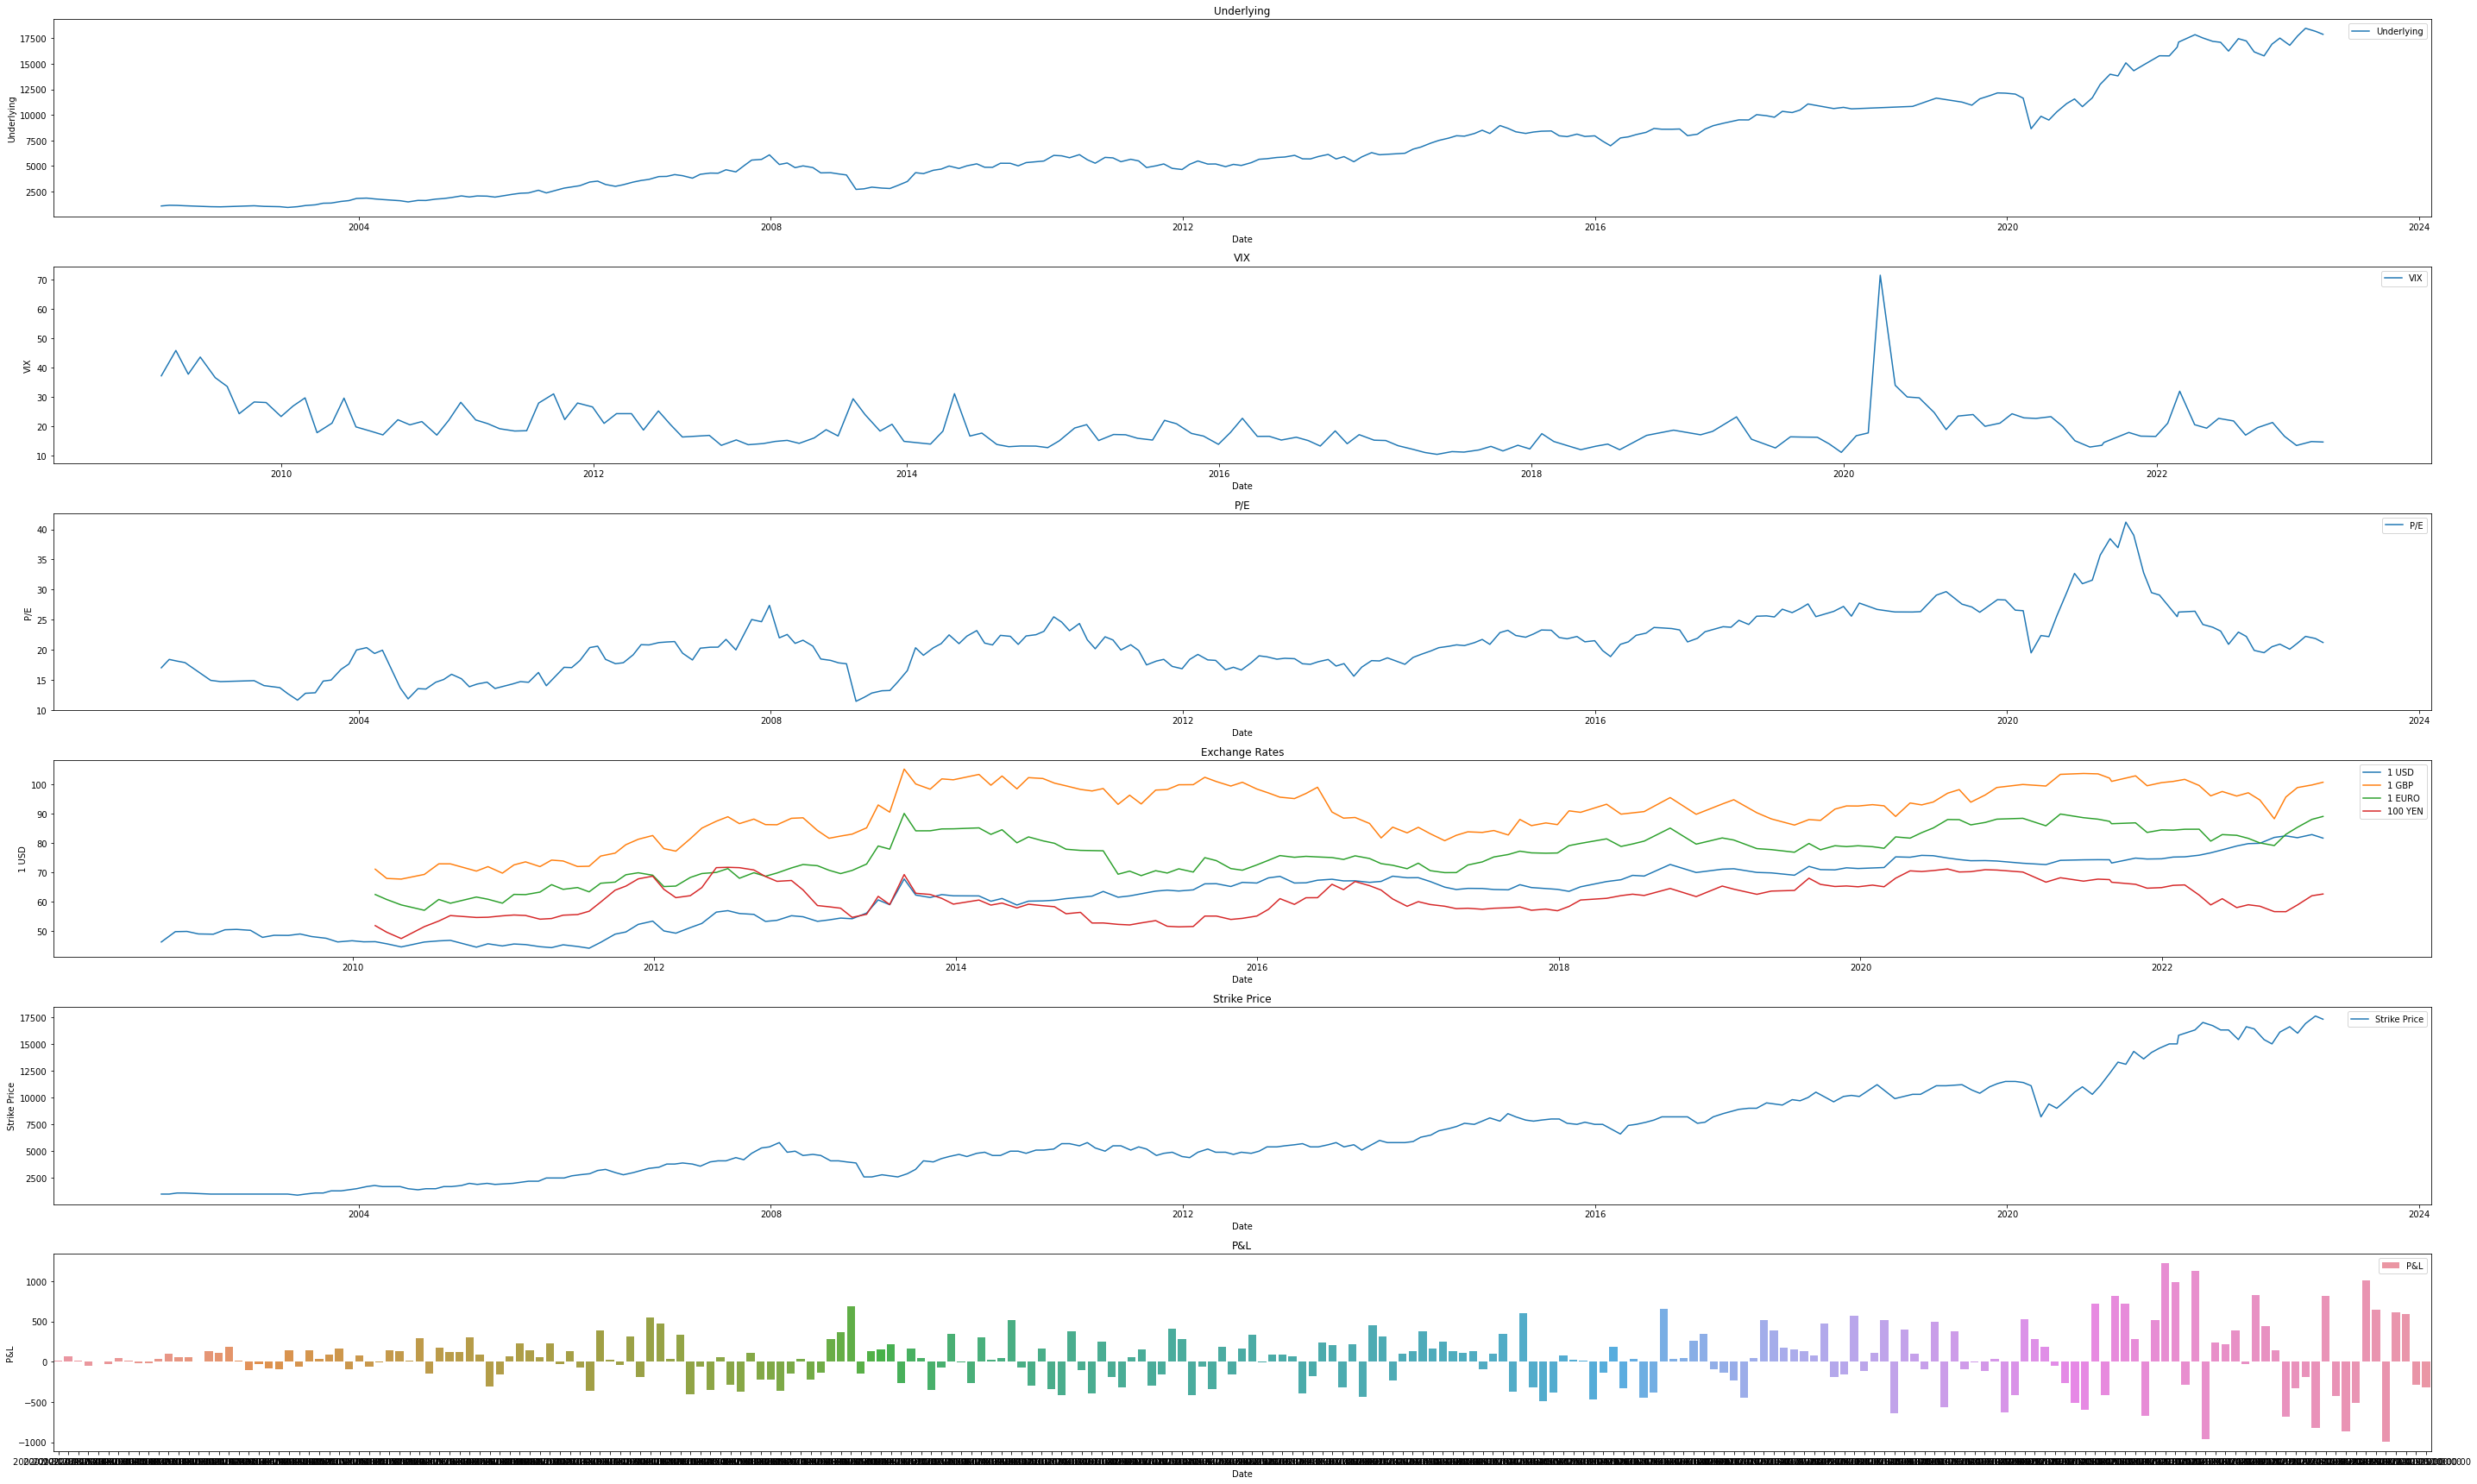

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = nifty_options
df['P&L'] = df['P&L'].round(0)

# Create a figure and subplots
fig, axs = plt.subplots(6, 1, figsize=(40, 24))

# Plot the data
sns.lineplot(x=df.index, y='Underlying', data=df, ax=axs[0], label='Underlying')
axs[0].set_title('Underlying')
axs[0].legend()

sns.lineplot(x=df.index, y='VIX', data=df, ax=axs[1], label='VIX')
axs[1].set_title('VIX')
axs[1].legend()

sns.lineplot(x=df.index, y='P/E', data=df, ax=axs[2], label='P/E')
axs[2].set_title('P/E')
axs[2].legend()

sns.lineplot(x=df.index, y='1 USD', data=df, ax=axs[3], label='1 USD')
sns.lineplot(x=df.index, y='1 GBP', data=df, ax=axs[3], label='1 GBP')
sns.lineplot(x=df.index, y='1 EURO', data=df, ax=axs[3], label='1 EURO')
sns.lineplot(x=df.index, y='100 YEN', data=df, ax=axs[3], label='100 YEN')
axs[3].set_title('Exchange Rates')
axs[3].legend()

sns.lineplot(x=df.index, y='Strike Price', data=df, ax=axs[4], label='Strike Price')
axs[4].set_title('Strike Price')
axs[4].legend()

sns.barplot(x=df.index, y='P&L', data=df, ax=axs[5], label='P&L')
axs[5].set_title('P&L')
axs[5].legend()

# Set the layout and display the plot
plt.tight_layout()
plt.show()

In [144]:
# save the figure in high resolution PDF format
fig.savefig('figure.pdf', dpi=300, bbox_inches='tight')

In [143]:
# Calculate the sum of the P&L column
pl_sum = df['P&L'].sum()

# Print the result
print(f'The sum of the P&L points is {pl_sum:.2f}')
print(f'The sum of the P&L rupees is {pl_sum*75:.2f}')

The sum of the P&L points is 8017.00
The sum of the P&L rupees is 601275.00


In [149]:
# calculate the average of the 'Buy Price' column
avg_buy_price = df['Buy Price'].mean()

# 75 lot size and 10 is std multiplier
print(f'{avg_buy_price*750:.2f}')

309125.16
